<a href="https://colab.research.google.com/github/waltersalles/previs-o_lstm_inflacao/blob/main/previs%C3%A3o_lstm_inflacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


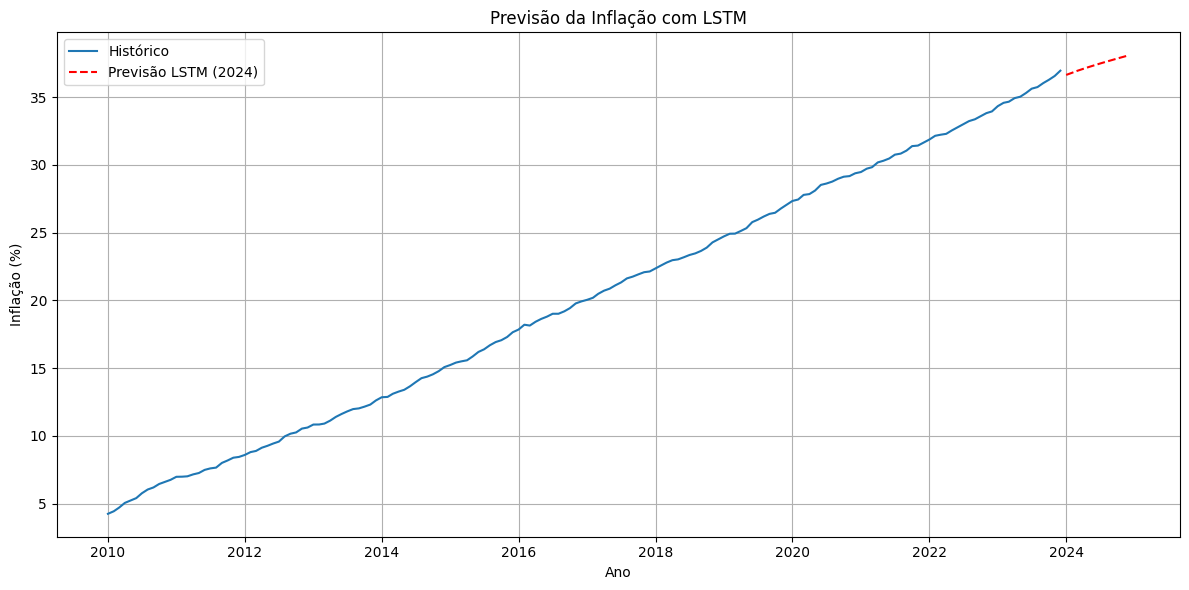

In [1]:
# previsão_lstm_inflacao.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Simulação de inflação mensal de 2010 a 2023
np.random.seed(42)
meses = pd.date_range(start="2010-01-01", end="2023-12-01", freq="MS")
inflacao = np.cumsum(np.random.normal(loc=0.2, scale=0.1, size=len(meses))) + 4

df = pd.DataFrame({'Data': meses, 'Inflação': inflacao})
df.set_index('Data', inplace=True)

# Normalização
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Criando dados de séries temporais
def criar_dados_temporais(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 12
X, y = criar_dados_temporais(df_scaled, look_back)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer=Adam(0.01), loss='mean_squared_error')
model.fit(X, y, epochs=50, batch_size=12, verbose=0)

# Previsão de 12 meses
entrada = df_scaled[-look_back:]
predicoes = []
for _ in range(12):
    entrada_reshaped = entrada.reshape((1, look_back, 1))
    pred = model.predict(entrada_reshaped, verbose=0)
    predicoes.append(pred[0, 0])
    entrada = np.append(entrada[1:], pred).reshape(-1, 1)

# Inverter a normalização
predicoes_reais = scaler.inverse_transform(np.array(predicoes).reshape(-1, 1))
futuras_datas = pd.date_range(start="2024-01-01", periods=12, freq="MS")

# Visualização
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Inflação'], label='Histórico')
plt.plot(futuras_datas, predicoes_reais, label='Previsão LSTM (2024)', linestyle='--', color='red')
plt.title("Previsão da Inflação com LSTM")
plt.xlabel("Ano")
plt.ylabel("Inflação (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
